# Exploratory data analysis (EDA)

This is the very first data analysis I do on my own. Please take the informations on this notebook with a grain of salt. I'm open to all improvements (even rewording), don't hesitate to leave me a comment or upvote if you found it useful. If I'm completely wrong somewhere or if my findings makes no sense don't hesitate to leave me a comment.

This work was influenced by some kernels of the same competition as well as the [Stanford: Statistical reasoning MOOC](https://lagunita.stanford.edu/courses/OLI/StatReasoning/Open/info)

The purpose of this EDA is to find insights which will serve us later in another notebook for Data cleaning/preparation/transformation which will ultimately be used into a machine learning algorithm.
We will proceed as follow:

<img src="http://sharpsightlabs.com/wp-content/uploads/2016/05/1_data-analysis-for-ML_how-we-use-dataAnalysis_2016-05-16.png" />

[Source](http://sharpsightlabs.com/blog/data-analysis-machine-learning-example-1/)

Where each steps (Data exploration, Data cleaning, Model building, Presenting results) will belongs to 1 notebook.
I will write down a lot of details in this notebook (even some which may seems obvious by nature), as a beginner it's important for me to do so.

## Preparations

For the preparations lets first import the necessary libraries and load the files needed for our EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [2]:
df = pd.read_csv('../input/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

From these informations we can already see that some features won't be relevant in our exploratory analysis as there are too much missing values (such as `Alley` and `PoolQC`). Plus there is so much features to analyse that it may be better to concentrate on the ones which can give us real insights. Let's just remove `Id` and the features with 30% or less `NaN` values.

In [4]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: Id, Alley, PoolQC, Fence, MiscFeature, 



<font color='chocolate'> Note: If we take the features we just removed and look at their description in the `data_description.txt` file we can deduct that these features may not be present on all houses (which explains the `NaN` values). In our next Data preparation/cleaning notebook we could tranform them into categorical dummy values.</font>

Now lets take a look at how the housing price is distributed

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


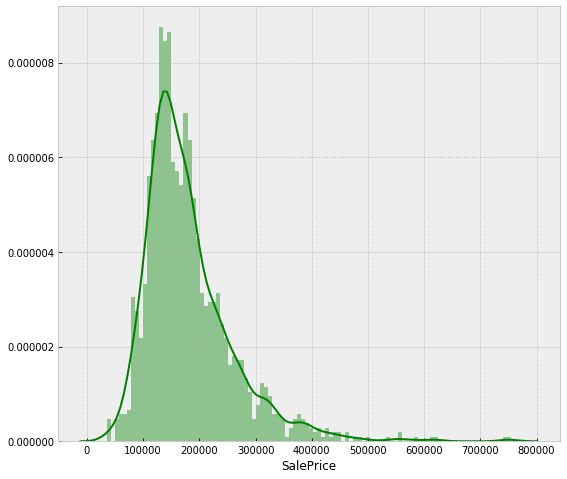

In [5]:
print(df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

<font color='chocolate'>With this information we can see that the prices are skewed right and some outliers lies above ~500,000. We will eventually want to get rid of the them to get a normal distribution of the independent variable (`SalePrice`) for machine learning.</font>

Note: Apparently using the log function could also do the job but I have no experience with it

## Numerical data distribution

For this part lets look at the distribution of all of the features by ploting them

To do so lets first list all the types of our data from our dataset and take only the numerical ones:

In [6]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [7]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


Now lets plot them all:

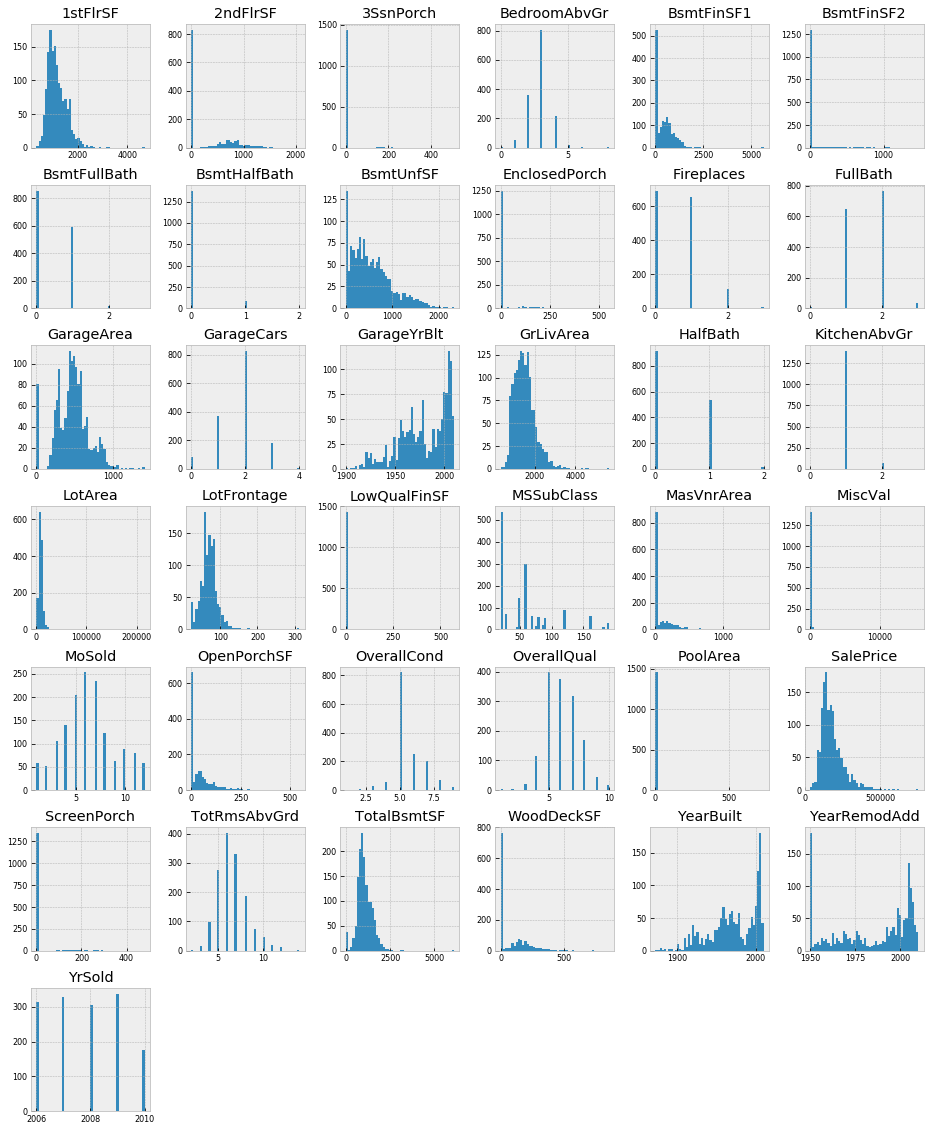

In [8]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

<font color='chocolate'>Features such as `1stFlrSF`, `TotalBsmtSF`, `LotFrontage`, `GrLiveArea`... seems to share a similar distribution to the one we have with `SalePrice`. Lets see if we can find new clues later.</font>

#### Correlation

Now we'll try to find which features are strongly correlated with `SalePrice`. We'll store them in a var called `golden_features_list`. We'll reuse our `df_num` dataset to do so.

In [9]:
df_num_corr = df_num.corr()['SalePrice'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 10 strongly correlated values with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


Perfect, we now have a list of strongly correlated values but this list is incomplete as we know that correlation is affected by outliers. So we could proceed as follow:

- Plot the numerical features and see which ones have very few or explainable outliers
- Remove the outliers from these features and see which one can have a good correlation without their outliers
    
Btw, correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the `SalePrice`. 

For example, relationships such as curvilinear relationship cannot be guessed just by looking at the correlation value so lets take the features we excluded from our correlation table and plot them to see if they show some kind of pattern.

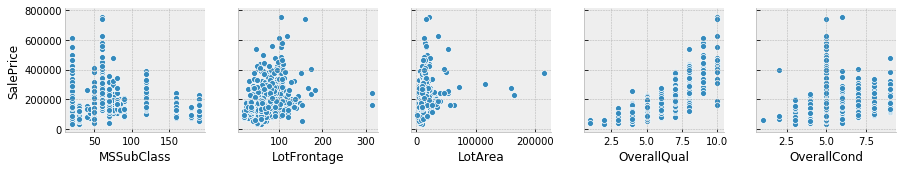

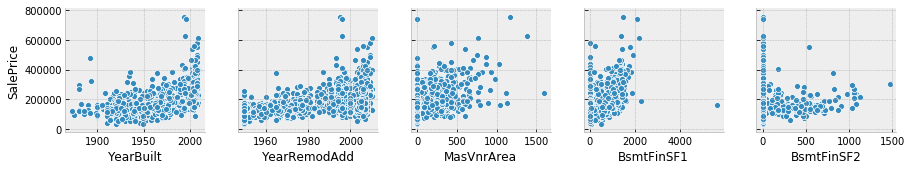

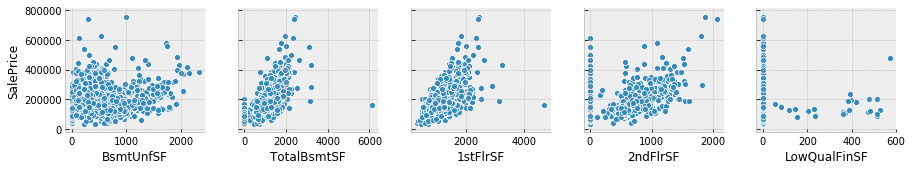

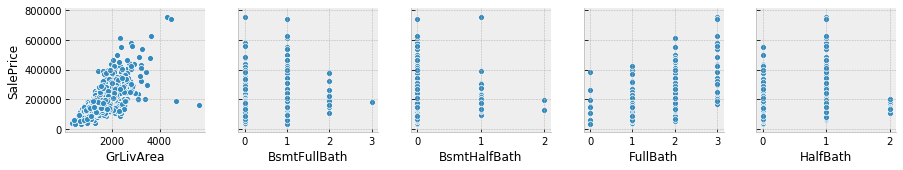

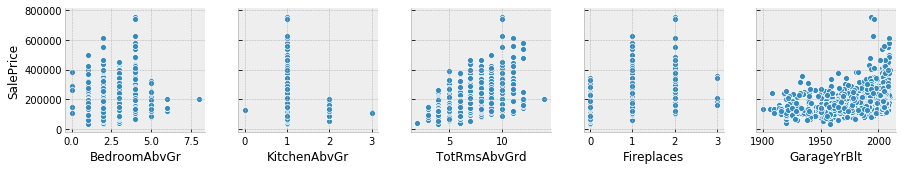

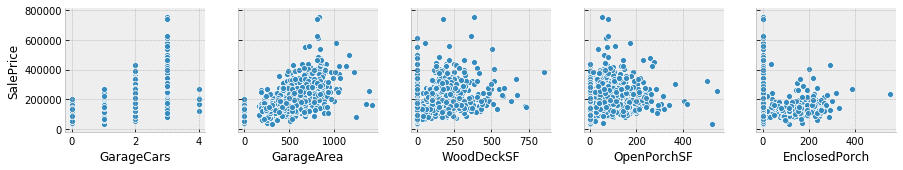

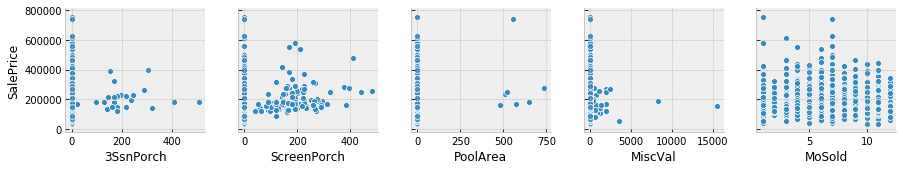

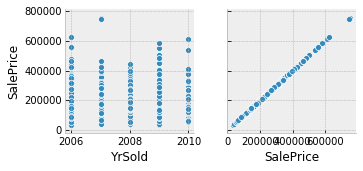

In [10]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['SalePrice'])

We can clearly identify some relationships. Most of them seems to have a linear relationship with the `SalePrice` and if we look closely at the data we can see that a lot of data points are located on `x = 0` which may indicate the absence of such feature in the house.

Take `OpenPorchSF`, I doubt that all houses have a porch (mine doesn't for instance but I don't lose hope that one day... yeah one day...).

So now lets remove these `0` values and repeat the process of finding correlated values: 

In [11]:
import operator

individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 because the last column is SalePrice
    tmpDf = df_num[[df_num.columns[i], 'SalePrice']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['SalePrice'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

   KitchenAbvGr: -0.13920069217785566
       HalfBath: -0.08439171127179887
     MSSubClass: -0.08428413512659523
    OverallCond: -0.0778558940486776
         YrSold: -0.028922585168730426
   BsmtHalfBath: -0.028834567185481712
       PoolArea: -0.014091521506356928
   BsmtFullBath: 0.011439163340408634
         MoSold: 0.04643224522381936
      3SsnPorch: 0.06393243256889079
    OpenPorchSF: 0.08645298857147708
        MiscVal: 0.08896338917298924
     Fireplaces: 0.1216605842136395
      BsmtUnfSF: 0.16926100049514192
   BedroomAbvGr: 0.18093669310849045
     WoodDeckSF: 0.19370601237520677
     BsmtFinSF2: 0.19895609430836586
  EnclosedPorch: 0.2412788363011751
    ScreenPorch: 0.25543007954878405
        LotArea: 0.2638433538714063
   LowQualFinSF: 0.3000750165550133
    LotFrontage: 0.35179909657067854
     MasVnrArea: 0.4340902197568926
     BsmtFinSF1: 0.4716904265235731
    GarageYrBlt: 0.48636167748786213
   YearRemodAdd: 0.5071009671113867
      YearBuilt: 0.5228973328794967

Very interesting! We found another strongly correlated value by cleaning up the data a bit. Now our `golden_features_list` var looks like this:

In [12]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 11 strongly correlated values with SalePrice:
['YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'GarageCars', '2ndFlrSF', 'GrLivArea', 'OverallQual']


<font color='chocolate'>We found strongly correlated predictors with `SalePrice`. Later with feature engineering we may add dummy values where value of a given feature > 0 would be 1 (precense of such feature) and 0 would be 0. 
<br />For `2ndFlrSF` for example, we could create a dummy value for its precense or non-precense and finally sum it up to `1stFlrSF`.</font>

### Conclusion

<font color='chocolate'>By looking at correlation between numerical values we discovered 11 features which have a strong relationship to a house price. Besides correlation we didn't find any notable pattern on the datas which are not correlated.</font>

Notes: 

- There may be some patterns I wasn't able to identify due to my lack of expertise
- Some values such as `GarageCars` -> `SalePrice` or `Fireplaces` -> `SalePrice` shows a particular pattern with verticals lines roughly meaning that they are discrete variables with a short range but I don't know if they need some sort of "special treatment".

## Feature to feature relationship

Trying to plot all the numerical features in a seaborn pairplot will take us too much time and will be hard to interpret. We can try to see if some variables are linked between each other and then explain their relation with common sense.

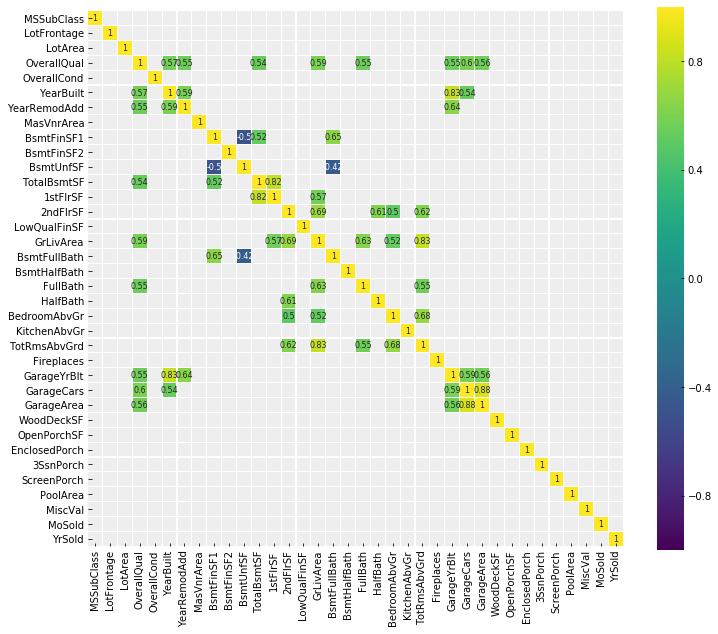

In [13]:
corr = df_num.drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

A lot of features seems to be correlated between each other but some of them such as `YearBuild`/`GarageYrBlt` may just indicate a price inflation over the years. As for `1stFlrSF`/`TotalBsmtSF`, it is normal that the more the 1st floor is large (considering many houses have only 1 floor), the more the total basement will be large.

Now for the ones which are less obvious we can see that:
- There is a strong negative correlation between `BsmtUnfSF` (Unfinished square feet of basement area) and `BsmtFinSF2` (Type 2 finished square feet). There is a definition of unfinished square feet [here](http://www.homeadvisor.com/r/calculating-square-footage/) but as for a house of "Type 2", I can't tell what it really is.
- `HalfBath`/`2ndFlrSF` is interesting and may indicate that people gives an importance of not having to rush downstairs in case of urgently having to go to the bathroom (I'll consider that when I'll buy myself a house uh...)

There is of course a lot more to discover but I can't really explain the rest of the features except the most obvious ones.

<font color='chocolate'>We can conclude that, by essence, some of those features may be combined between each other in order to reduce the number of features (`1stFlrSF`/`TotalBsmtSF`, `GarageCars`/`GarageArea`) and others indicates that people expect multiples features to be packaged together.</font>

## Q -> Q (Quantitative to Quantitative relationship)

Let's now examine the quantitative features of our dataframe and how they relate to the `SalePrice` which is also quantitative (hence the relation Q -> Q). I will conduct this analysis with the help of the [Q -> Q chapter of the Standford MOOC](https://lagunita.stanford.edu/courses/OLI/StatReasoning/Open/courseware/eda_er/_m5_case_III/)

Some of the features of our dataset are categorical. To separate the categorical from quantitative features lets refer ourselves to the `data_description.txt` file. According to this file we end up with the folowing columns:

In [14]:
quantitative_features_list = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,196.0,706,0,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500
1,80.0,9600,0.0,978,0,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500
2,68.0,11250,162.0,486,0,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500
3,60.0,9550,0.0,216,0,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,140000
4,84.0,14260,350.0,655,0,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000


Still, we have a lot of features to analyse here so let's take the *strongly correlated quantitative* features from this dataset and analyse them one by one

In [15]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse.append('SalePrice')
features_to_analyse

['TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice']

Let's look at their distribution.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


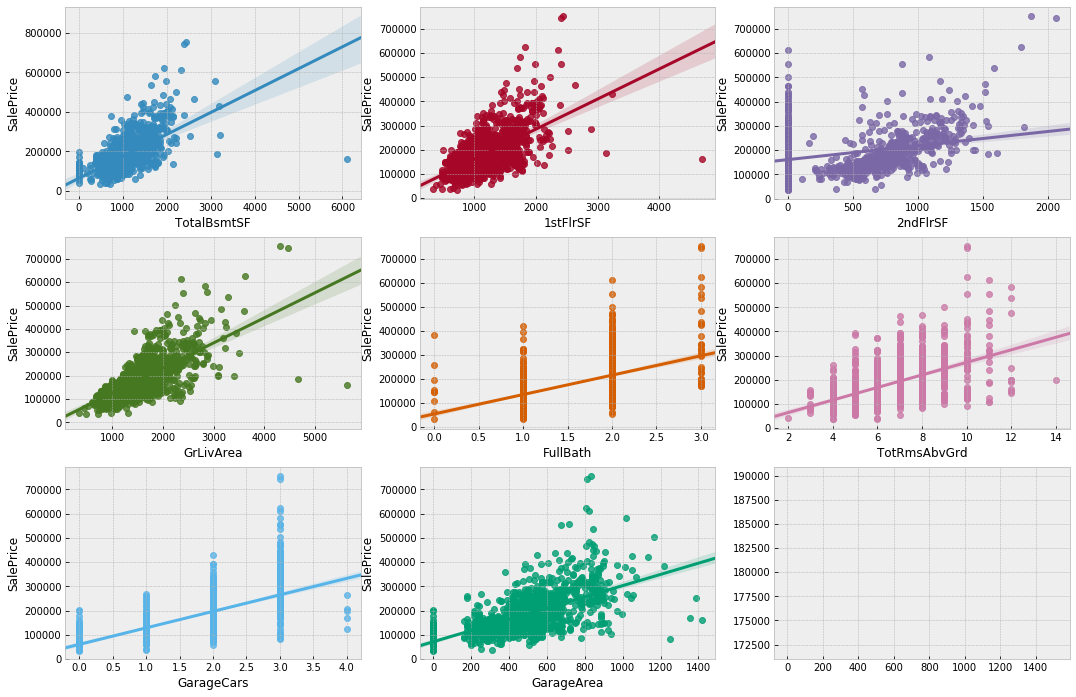

In [16]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='SalePrice', data=df[features_to_analyse], ax=ax)

We can see that features such as `TotalBsmtSF`, `1stFlrSF`, `GrLivArea` have a big spread but I cannot tell what insights this information gives us

## C -> Q (Categorical to Quantitative relationship)

We will base this part of the exploration on the [C -> Q chapter of the Standford MOOC](https://lagunita.stanford.edu/courses/OLI/StatReasoning/Open/courseware/eda_er/_m3_case_I/)


Lets get all the categorical features of our dataset and see if we can find some insight in them.
Instead of opening back our `data_description.txt` file and checking which data are categorical, lets just remove `quantitative_features_list` from our entire dataframe.

In [17]:
# quantitative_features_list[:-1] as the last column is SalePrice and we want to keep it
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,150,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,2003.0,RFn,TA,TA,Y,2,2008,WD,Normal,208500
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,284,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,1976.0,RFn,TA,TA,Y,5,2007,WD,Normal,181500
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,434,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2001.0,RFn,TA,TA,Y,9,2008,WD,Normal,223500
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,540,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,1998.0,Unf,TA,TA,Y,2,2006,WD,Abnorml,140000
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,490,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2000.0,RFn,TA,TA,Y,12,2008,WD,Normal,250000


And don't forget the non-numerical features

In [18]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 39 non numerical features including:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


<font color='chocolate'>Looking at these features we can see that a lot of them are of the type `Object(O)`. In our data transformation notebook we could use [Pandas categorical functions](http://pandas.pydata.org/pandas-docs/stable/categorical.html) (equivalent to R's factor) to shape our data in a way that would be interpretable for our machine learning algorithm. `ExterQual` for instace could be transformed to an ordered categorical object.</font>

Now lets plot some of them

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

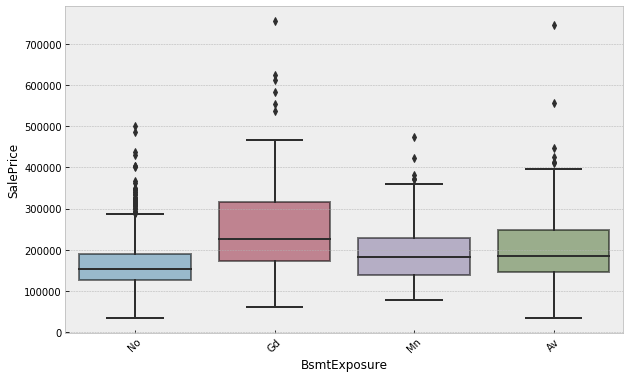

In [19]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='BsmtExposure', y='SalePrice', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

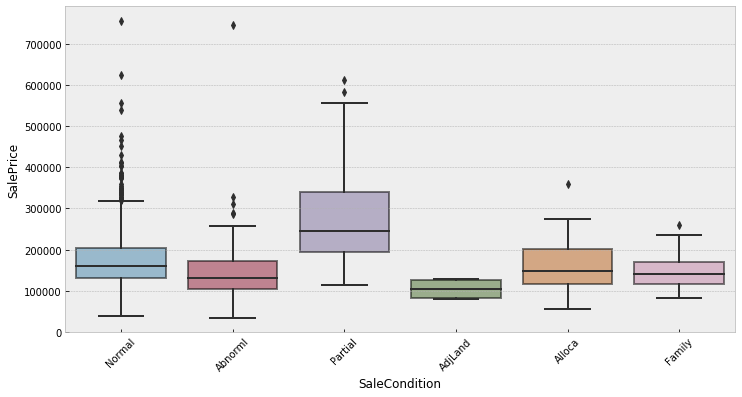

In [20]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x='SaleCondition', y='SalePrice', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

And finally lets look at their distribution

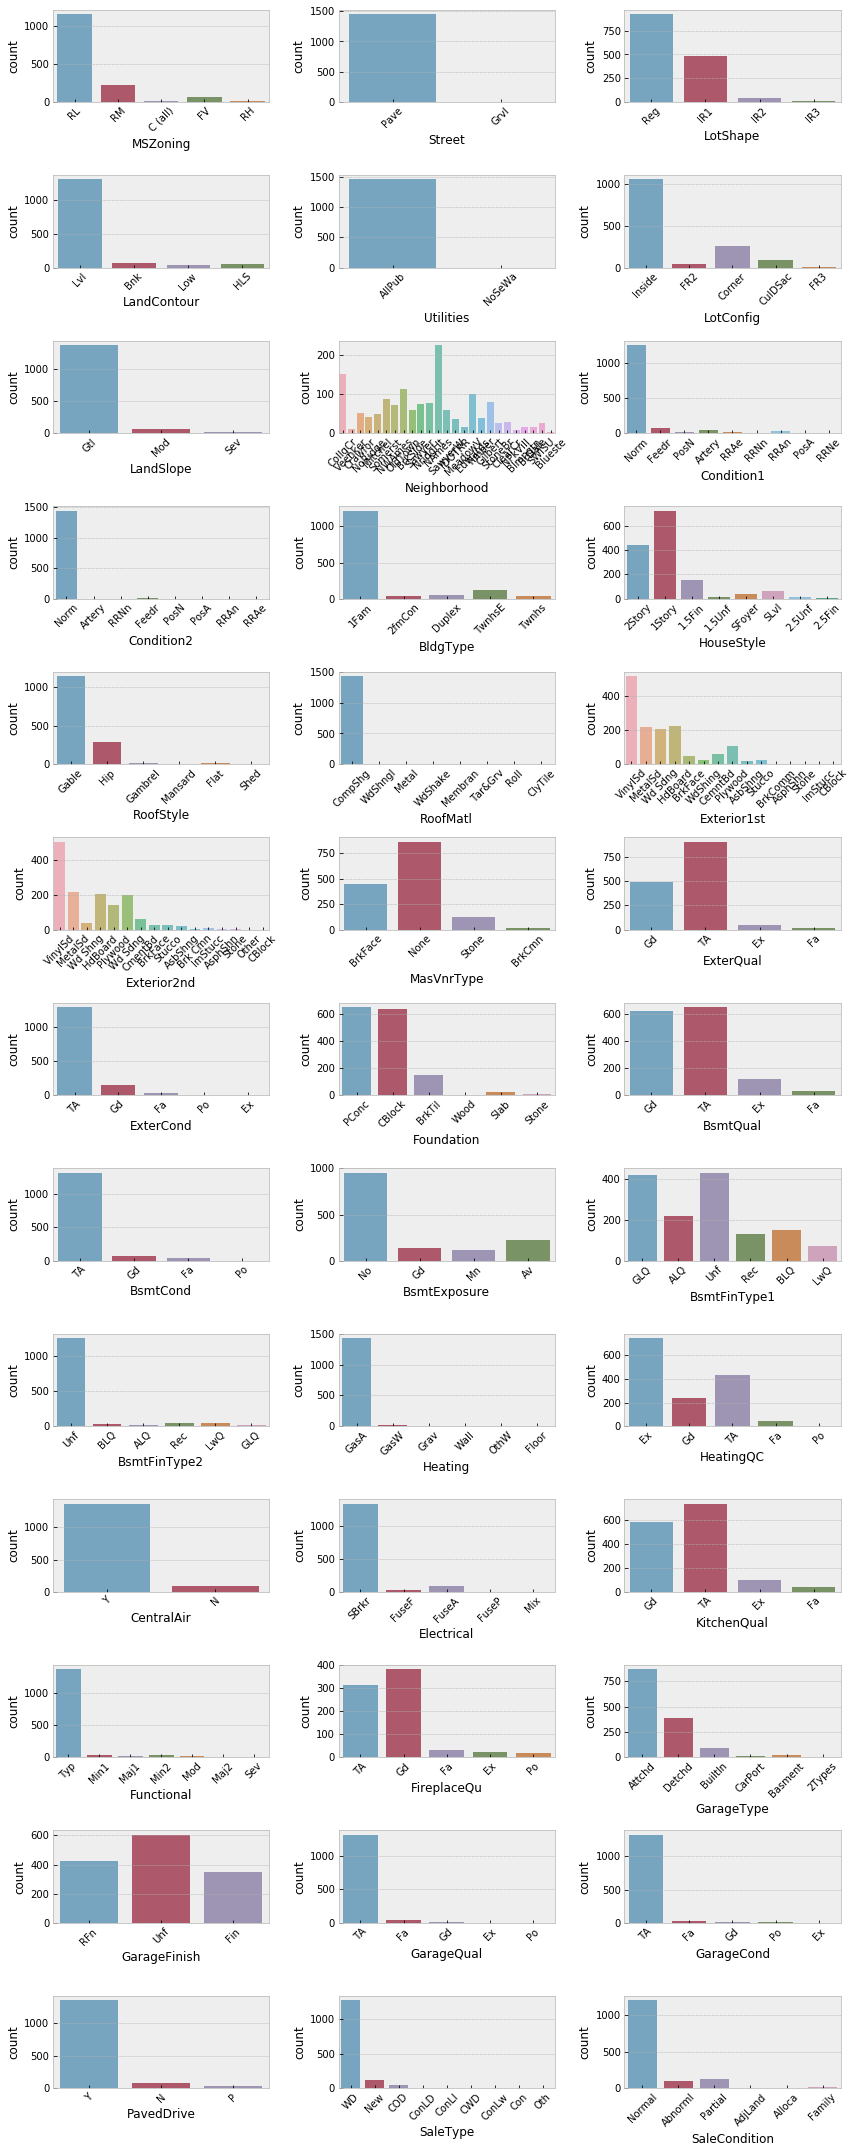

In [21]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

<font color='chocolate'>We can see that some categories are predominant for some features such as `Utilities`, `Heating`, `GarageCond`, `Functional`... These features may not be relevant for our predictive model</font>